In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import cv2
import os
import tensorflow as tf


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16377933510708221885
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14378926080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1375882308612317131
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
fold_num = 1

# Image size
img_width, img_height, img_depth = 256, 256, 3
DATADIRTRAIN = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train'
DATADIRVALID = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test'

#Training parameters
epochs = 10 #More Epochs doesn't improve validation accuracy
freq = 20
batch_size = 32 #This size because dataset is tiny
num_classes = 2
train_valid_split = 0.2 

class_weights = {0: 2.,
                1: 1.,
                2: 1.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'


#Data Creation
df_train = tf.keras.utils.image_dataset_from_directory(DATADIRTRAIN, labels='inferred', label_mode = class_mode, batch_size = batch_size, image_size = (img_width, img_height), shuffle = True, seed = 1, validation_split = train_valid_split, subset="training")
df_valid = tf.keras.utils.image_dataset_from_directory(DATADIRTRAIN, labels='inferred', label_mode = class_mode, batch_size = batch_size, image_size = (img_width, img_height), shuffle = True, seed = 1, validation_split = train_valid_split, subset="validation")

Found 2534 files belonging to 2 classes.
Using 2028 files for training.
Found 2534 files belonging to 2 classes.
Using 506 files for validation.


In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    fill_mode = 'constant',
    validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    directory = DATADIRTRAIN,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'training'
)

valid_generator = datagen.flow_from_directory(
    directory = DATADIRTRAIN,
    class_mode = class_mode,
    batch_size = batch_size,
    subset = 'validation'
)

Found 2028 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


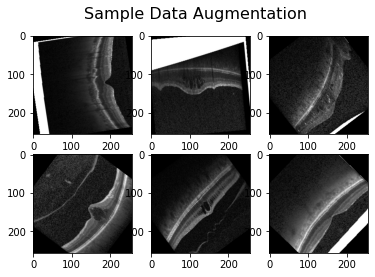

y Labels:  [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [ ]:
#For Directory
#Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

In [ ]:
# Build Model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                 include_top = False,
                                 weights = 'imagenet')

base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers[:-9]:
    layer.trainable = False

model = Model(image_input, output)

# model.summary()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Compiling the model
opt = Adam(learning_rate = 0.00001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])

In [ ]:
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, save_freq = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0,
                              mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

# Display model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
history = model.fit_generator(train_generator,
                              epochs = epochs,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = valid_generator,
                              validation_steps = valid_generator.samples // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

<ipython-input-9-c1c5ef1a59a5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
19/63 [========>.....................] - ETA: 2:07 - loss: 1.2088 - accuracy: 0.5526
Epoch 1: saving model to trained_models_20230323_034139_fold_num1/model_1_model.0001.hdf5
39/63 [=================>............] - ETA: 1:20 - loss: 1.1298 - accuracy: 0.5757
Epoch 1: saving model to trained_models_20230323_034139_fold_num1/model_1_model.0001.hdf5
59/63 [===========================>..] - ETA: 14s - loss: 1.0770 - accuracy: 0.5905
Epoch 1: saving model to trained_models_20230323_034139_fold_num1/model_1_model.0001.hdf5
63/63 [==============================] - 298s 5s/step - loss: 1.0644 - accuracy: 0.5947 - val_loss: 0.7203 - val_accuracy: 0.5896
Epoch 2/10
16/63 [======>.......................] - ETA: 33s - loss: 0.7286 - accuracy: 0.7285
Epoch 2: saving model to trained_models_20230323_034139_fold_num1/model_1_model.0002.hdf5
36/63 [================>.............] - ETA: 33s - loss: 0.5794 - accuracy: 0.7856
Epoch 2: saving model to trained_models_20230323_034139_fold_num1/